In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

The ImageDataGenerator class in TensorFlow provides a way to apply data augmentation and normalization to the input images during training. The rescale argument is used to normalize the pixel values of the images by dividing them by 255, which scales the pixel values to the range of [0,1]. The shear_range, zoom_range, and horizontal_flip arguments etc.., are used to apply random transformations to the images, which helps the model learn to recognize the object of interest from different perspectives and orientations.

The train_datagen object is used to apply data augmentation to the training images, while the test_datagen object is used to normalize the test images. It is important to only apply normalization to the validation and test sets, but not data augmentation, as we want to evaluate the model's performance on the original, unmodified images.

Train_datagen.flow_from_directory() method is used to create a data generator that reads images from the training directory.

In [122]:
# Set the directory paths
train_dir = "C:\\Users\\gumma\\OneDrive\\Desktop\\Deep Learning Bike\\Train"

valid_dir = "C:\\Users\\gumma\\OneDrive\\Desktop\\Deep Learning Bike\\Validation"


# Set the image size and batch size
image_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=20,  # randomly rotate images by 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1,  # randomly shift images vertically by 10%
    shear_range=0.1,  # randomly shear images by 10%
    zoom_range=0.1,  # randomly zoom images by 10%
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest'  # fill any pixels that are lost during transformation
)


valid_datagen= ImageDataGenerator(rescale=1./255)


# Generate batches of training,testing and validation data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary')
valid_generator= valid_datagen.flow_from_directory(valid_dir, target_size=image_size, batch_size=batch_size, class_mode='binary')

Found 263 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


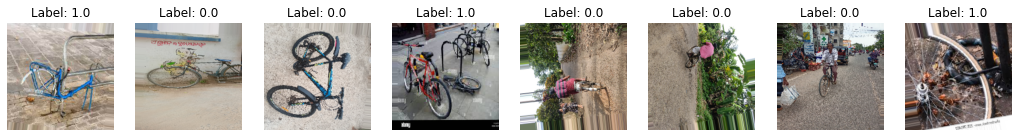

In [35]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training generator
x_batch, y_batch = next(train_generator)

# Display the first 8 images and their labels
fig, ax = plt.subplots(1, 8, figsize=(18, 6))
for i in range(8):
    ax[i].imshow(x_batch[i])
    ax[i].set_title('Label: {}'.format(y_batch[i]))
    ax[i].axis('off')
plt.show()


base_model = InceptionV3(weights='imagenet', include_top=False): Load the pre-trained InceptionV3 model from Keras applications with the pre-trained weights from the ImageNet dataset. include_top=False means that the final fully-connected layer of the model is excluded, so that it can be replaced by a new output layer.

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions): Create a new Keras model that takes the input from the pre-trained InceptionV3 model and outputs the predictions from the new output layer.

**First Ran the model with all the weights in base model frozen, then again by fine tuning the model by Unfreezing the top layers becasue**

Unfreezing only the top layers of the pre-trained model because these layers are typically the ones that are most specific to the original task the model was trained on, and therefore the ones that are most likely to need updating for a new task. Lower layers in the model tend to learn more general features that are likely to be useful across many different tasks, so we want to keep these weights frozen and leverage their knowledge.

By selectively unfreezing the top layers of the pre-trained model, we can fine-tune the model to better recognize the specific features of our new dataset without completely overwriting the useful knowledge that the pre-trained model has already learned.

In [4]:
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global average pooling layer and a fully-connected output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model to be trained
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for a few epochs with frozen layers
model.fit_generator(train_generator, epochs=5, validation_data=valid_generator)

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for a few more epochs with unfrozen layers
model.fit_generator(train_generator, epochs=10, validation_data=valid_generator)


87910968/87910968 [==============================] - 3s 0us/step


C:\Users\gumma\AppData\Local\Temp\ipykernel_21384\942963278.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=5, validation_data=valid_generator)


Epoch 1/5
9/9 [==============================] - 107s 12s/step - loss: 1.9438 - accuracy: 0.6388 - val_loss: 0.9440 - val_accuracy: 0.6604
Epoch 2/5
9/9 [==============================] - 76s 8s/step - loss: 0.3313 - accuracy: 0.8555 - val_loss: 0.4364 - val_accuracy: 0.8302
Epoch 3/5
9/9 [==============================] - 74s 8s/step - loss: 0.1297 - accuracy: 0.9468 - val_loss: 0.3842 - val_accuracy: 0.8868
Epoch 4/5
9/9 [==============================] - 83s 9s/step - loss: 0.1308 - accuracy: 0.9582 - val_loss: 0.3703 - val_accuracy: 0.8868
Epoch 5/5
9/9 [==============================] - 76s 9s/step - loss: 0.1344 - accuracy: 0.9658 - val_loss: 0.3288 - val_accuracy: 0.8868


C:\Users\gumma\AppData\Local\Temp\ipykernel_21384\942963278.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=10, validation_data=valid_generator)


Epoch 1/10
9/9 [==============================] - 92s 9s/step - loss: 0.3089 - accuracy: 0.8973 - val_loss: 0.9157 - val_accuracy: 0.7736
Epoch 2/10
9/9 [==============================] - 69s 8s/step - loss: 0.2055 - accuracy: 0.9354 - val_loss: 0.3049 - val_accuracy: 0.9057
Epoch 3/10
9/9 [==============================] - 69s 8s/step - loss: 0.0734 - accuracy: 0.9772 - val_loss: 0.2465 - val_accuracy: 0.8679
Epoch 4/10
9/9 [==============================] - 75s 8s/step - loss: 0.1207 - accuracy: 0.9544 - val_loss: 0.2422 - val_accuracy: 0.8679
Epoch 5/10
9/9 [==============================] - 69s 8s/step - loss: 0.0616 - accuracy: 0.9696 - val_loss: 0.3756 - val_accuracy: 0.9245
Epoch 6/10
9/9 [==============================] - 76s 8s/step - loss: 0.0684 - accuracy: 0.9772 - val_loss: 0.2322 - val_accuracy: 0.8679
Epoch 7/10
9/9 [==============================] - 74s 9s/step - loss: 0.0179 - accuracy: 0.9962 - val_loss: 0.4153 - val_accuracy: 0.9245
Epoch 8/10
9/9 [==================

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [6]:
model.save("C:\\Users\\gumma\\OneDrive\\Desktop\\Deep Learning Bike\\Model")

INFO:tensorflow:Assets written to: C:\Users\gumma\OneDrive\Desktop\Deep Learning Bike\Model\assets


INFO:tensorflow:Assets written to: C:\Users\gumma\OneDrive\Desktop\Deep Learning Bike\Model\assets


In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('C:\\Users\\gumma\\OneDrive\\Desktop\\Deep Learning Bike\\Model')


In [24]:
#Test on New Data

# Define the target image size
img_size = (224, 224)

# Load and preprocess the input image
img_path ="C:\\Users\\gumma\\Downloads\\WhatsApp Image 2023-04-21 at 11.39.18 AM.jpeg"
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Make the prediction
prediction = model.predict(img_array)[0][0]
probability = round(prediction, 2)
if prediction < 0.5:
    print("No theft detected. Probability: {}".format(probability))
else:
    print("Theft detected. Probability: {}".format(probability))


1/1 [==============================] - 0s 93ms/step
No theft detected. Probability: 0.10999999940395355


Found 17 images belonging to 2 classes.


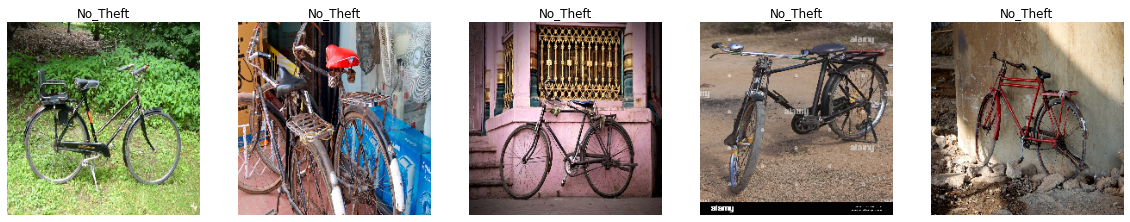

In [117]:
import matplotlib.pyplot as plt
np.random.seed(123)

test_dir = "C:\\Users\\gumma\\OneDrive\\Desktop\\Deep Learning Bike\\Saved_Images"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=False)

# Get some random images and labels from the test_generator
x_test, y_test = test_generator.next()
num_samples = 5

# Show the images and their true labels
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20, 5))
for i in range(num_samples):
    img = x_test[i]
    true_label = 'No_Theft' if y_test[i] == 0 else 'Theft'
    axes[i].imshow(img)
    axes[i].set_title(true_label)
    axes[i].axis('off')
plt.show()


1/1 [==============================] - 1s 1s/step
Accuracy: 76.47%
Confusion Matrix:
 TN: 6, FP: 2, FN: 2, TP: 7


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

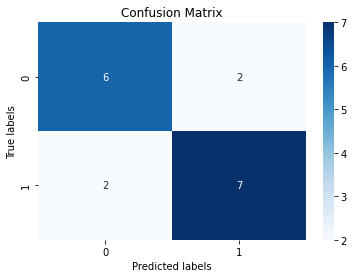

In [120]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the threshold for classifying as 'bike' to 0.75
threshold = 0.75

# Generate predictions on the test set
test_generator.reset()  # reset the generator to start at the beginning of the dataset
y_pred_proba = model.predict(test_generator)  # get predicted probabilities
y_pred = np.where(y_pred_proba > threshold, 1, 0)  # convert probabilities to binary predictions

# Get the true labels
y_true = test_generator.classes

# Print accuracy and confusion matrix
acc = np.mean(y_pred.ravel() == y_true.ravel()) * 100
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f"Accuracy: {acc:.2f}%")
print(f"Confusion Matrix:\n TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])





1/1 [==============================] - 1s 582ms/step


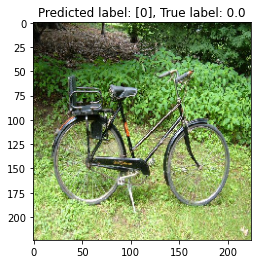

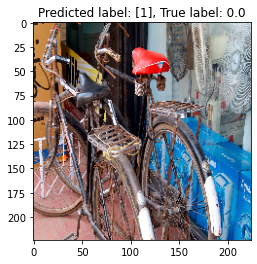

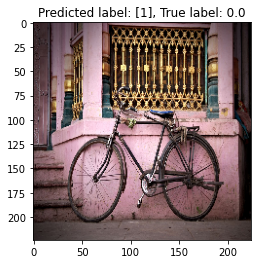

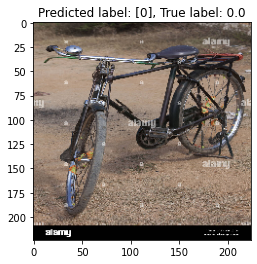

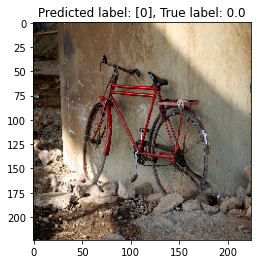

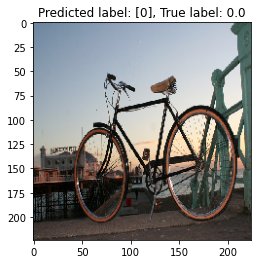

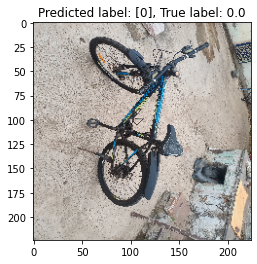

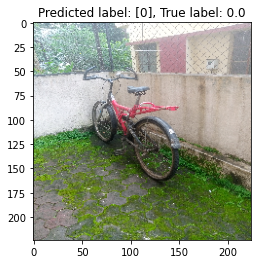

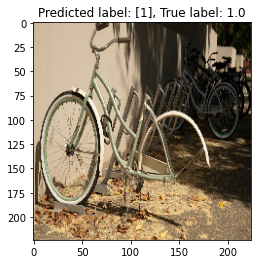

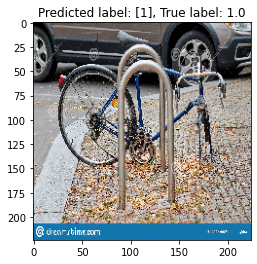

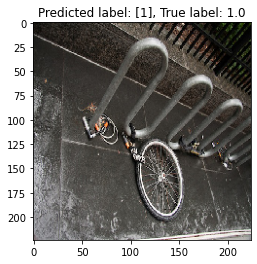

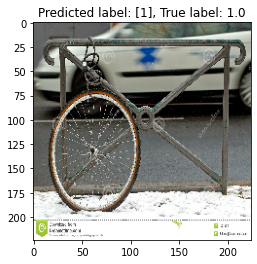

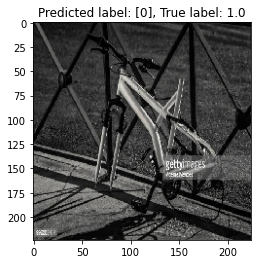

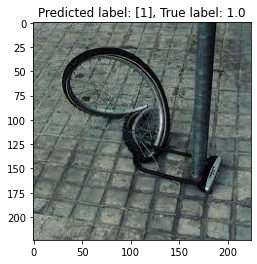

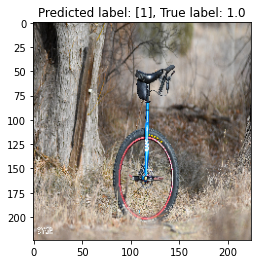

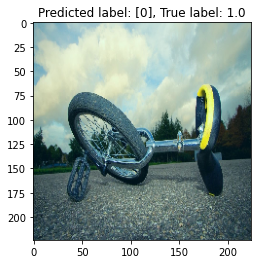

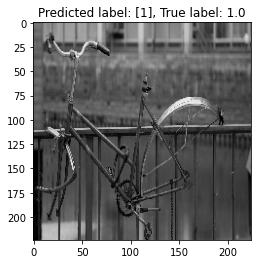

In [121]:
# Display images in test set with their predicted labels
test_generator.reset()
for i in range(len(test_generator)):
    x, y_true = test_generator[i]
    y_pred_proba = model.predict(x)
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    for j in range(len(x)):
        plt.imshow(x[j])
        plt.title(f"Predicted label: {y_pred[j]}, True label: {y_true[j]}")
        plt.show()